# Stress Fibers Detection Project 
### All Images

<a id="home"></a>


| Section| Topic |
| :- | :- |
| 1 |  [Images Pre-Proccessing](#Pre_Proccessing) | 
| 2 |  [Cell Borders Detection](#Cell_Borders) | 
| 3 |  [Stress Fibers Detection](#Fibers) | 
| 4 |  [Analyze](#Analyze) | 
| 5 |  [Summary](#summarize) | 

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi, threshold_otsu
from skimage.exposure import rescale_intensity
from scipy.ndimage import maximum_filter, minimum_filter
import pandas as pd

In [2]:
def show(*args):
    images = len(args)
    rows = int(np.ceil(images / 5.0))   
    cols = min(5, images)              

    fig, ax = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

    for i, img in enumerate(args):
        if rows == 1:  
            if cols == 1: 
                ax.imshow(img, cmap='gray')
            else:  
                ax[i].imshow(img, cmap='gray')
        else: 
            row = i // 5
            col = i % 5
            ax[row, col].imshow(img, cmap='gray')

    if images < rows * cols:
        for i in range(images, rows * cols):
            fig.delaxes(ax.flatten()[i])
    plt.tight_layout()
    plt.show()

[Go to the beginning of the assignment](#home)

[Go to summary](#summarize)

<a id="Pre_Proccessing"></a>
## Images Pre-Proccessing

In [3]:
def enhance_contrast(layer: np.ndarray):
    if layer.dtype != np.uint8:
        layer = cv2.normalize(layer, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    equalized = cv2.equalizeHist(layer)
    return equalized

In [4]:
def emphasize_boundaries(layer: np.ndarray):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded = cv2.erode(layer, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    return dilated

In [5]:
def combine_layers(layers: list):
    combined = np.maximum.reduce(layers)
    combined = cv2.normalize(combined, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return combined

In [6]:
def gamma_correction(image: np.ndarray, gamma: float):
    return (np.power(image, gamma))*255

In [7]:
def normalize_image(image: np.ndarray):
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return normalized_image

In [8]:
def enhance_and_bound_image_layers(image_path: str):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    stacked_layers = cv2.split(image)
    tiff_stack = cv2.imreadmulti(image_path)[1]
    enhanced_layers = []
    for layer in stacked_layers:
        enhanced = enhance_contrast(layer)
        emphasized = emphasize_boundaries(enhanced)
        enhanced_layers.append(emphasized)

    bounded_img = tiff_stack[-1] - tiff_stack[1]
    bounded_img = cv2.GaussianBlur(bounded_img, (35,35), 10)
    bounded_img[bounded_img > 0] = 255

    final_output = combine_layers(enhanced_layers)        
    final_output[bounded_img == 0] = 0
    
    return final_output

In [9]:
def process_images(image_files: list):
    processed_images = []

    for file in image_files:
        processed_image = enhance_and_bound_image_layers(file)
        processed_images.append(processed_image)

    gamma_values = [2, 3]
    gamma_images_lists = []

    for processed_image in processed_images:
        normalized_image = processed_image / 255
        gamma_images = [normalize_image(gamma_correction(normalized_image, gamma)) for gamma in gamma_values]
        gamma_images_lists.append(gamma_images)

    current_images = [gamma_images[1] for gamma_images in gamma_images_lists]

    normalized_images = [normalize_image(current_image) for current_image in current_images]

    gamma_images_0 = [gamma_images[0] for gamma_images in gamma_images_lists]

    return normalized_images, gamma_images_0

[Go to the beginning of the assignment](#home)

[Go to summary](#summarize)

<a id="Cell_Borders"></a>
## Cell Borders Detection

In [10]:
def connect_cell_regions(thresh: np.ndarray, min_cell_length: int = 50):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    cells_mask = np.zeros_like(thresh)

    for i in range(1, num_labels):
        if max(stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]) > min_cell_length:
            cells_mask[labels == i] = 255

    return cells_mask

In [11]:
def find_cell_mask(current_image: np.ndarray, blur_kernel: tuple, threshold_value: int, outer_line_filter: int,
                   kernel_open_size: tuple, kernel_close_size: tuple, erode_kernel_size: tuple,
                   dilate_kernel_size: tuple, outer_lines: list, connect_regions_threshold: int = 50) -> np.ndarray:
    blur = cv2.GaussianBlur(current_image, blur_kernel, 0)

    ret, thresh = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY_INV)
    _, outer_line = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV)
    outer_line = maximum_filter(outer_line, outer_line_filter)

    outer_lines.append(outer_line)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_open_size)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_close_size)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    cells_mask = connect_cell_regions(thresh, connect_regions_threshold)

    shape = cv2.MORPH_RECT
    erode_kernel = cv2.getStructuringElement(shape, erode_kernel_size)
    cells_mask = cv2.erode(cells_mask, erode_kernel, iterations=2)

    dilate_kernel = cv2.getStructuringElement(shape, dilate_kernel_size)
    cells_mask_result = cv2.dilate(cells_mask, dilate_kernel)

    return cells_mask_result

[Go to the beginning of the assignment](#home)

[Go to summary](#summarize)

<a id="Fibers"></a>
## Identify Stress Fibers

In [12]:
def process_test_images(current_images: list, cells_masks: list, outer_lines: list) -> list:
    processed_tests = []
    for current_image, cells_mask, outer_line in zip(current_images, cells_masks, outer_lines):
        test = current_image.copy()
        test[cells_mask == 0] = 0
        test[current_image <= 30] = 0
        test[outer_line > 0] = 0
        processed_tests.append(test)
    return processed_tests

In [13]:
def equalize_hist(img: np.ndarray) -> np.ndarray:
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    
    img_out = cdf[img.flatten().astype('uint8')]
    img_out = np.reshape(img_out, img.shape)

    return img_out

In [14]:
def equalize_images(tests: list, processed_images: list) -> (list, list):
    equalized_test_images = [equalize_hist(test) for test in tests]
    equalized_processed_images = [equalize_hist(img) for img in processed_images]
    return equalized_test_images, equalized_processed_images

In [15]:
def process_frangi_filtered_image(equalized_processed_image: np.ndarray, cells_mask: np.ndarray, outer_line: np.ndarray) -> np.ndarray:
    filtered_frangi = frangi(equalized_processed_image, np.arange(0.5, 3, 1.5), beta=0.3, black_ridges=False)
    filtered_frangi[cells_mask == 0] = 0 
    filtered_frangi = minimum_filter(filtered_frangi, 2) 
    filtered_frangi[outer_line > 0] = 0 

    ed_frangi = cv2.dilate(filtered_frangi, (10,) * 2)
    ed_frangi = cv2.erode(ed_frangi, (5,) * 2)

    ed_frangi = cv2.dilate(ed_frangi, (9,) * 2)
    ed_frangi = cv2.erode(ed_frangi, (3,) * 2)

    ed_frangi = cv2.erode(ed_frangi, (5,) * 2)
    ed_frangi = cv2.dilate(ed_frangi, (5,) * 2)

    ed_frangi = cv2.erode(ed_frangi, (15,) * 2)
    ed_frangi = cv2.dilate(ed_frangi, (5,) * 2)
    
    normalized_image = cv2.normalize(ed_frangi, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    eq_image = cv2.equalizeHist(normalized_image)
    
    return eq_image

In [16]:
def convert_gray_to_rgb(image: np.ndarray) -> np.ndarray:
    image_rgb = np.stack((image,) * 3, axis=-1)
    return image_rgb

In [17]:
def highligh_fibers(eq_image: np.ndarray, equalized_test_image: np.ndarray, equalized_normalized_image: np.ndarray) -> None:
    image_color = convert_gray_to_rgb(equalized_test_image)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image1 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)

    image_color = convert_gray_to_rgb(equalized_normalized_image)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image2 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
    
    show(highlighted_image1, highlighted_image2)

In [18]:
def identify_fibers(gamma_images_0: list, cells_masks: list, outer_lines: list, processed_images: list) -> list:
    tests = process_test_images(gamma_images_0, cells_masks, outer_lines)
    equalized_test_images, equalized_processed_images = equalize_images(tests, processed_images)
    
    fibers_masks = []
    
    for equalized_processed_image, cells_mask, outer_line in zip(equalized_processed_images, cells_masks, outer_lines):
        fibers_mask = process_frangi_filtered_image(equalized_processed_image, cells_mask, outer_line)
        fibers_masks.append(fibers_mask)
        
    for fibers_mask, equalized_test_image, equalized_processed_image in zip(fibers_masks, equalized_test_images, equalized_processed_images):
        highligh_fibers(fibers_mask, equalized_test_image, equalized_processed_image)
    
    return fibers_masks

[Go to the beginning of the assignment](#home)

[Go to summary](#summarize)

<a id="Analyze"></a>
## Analyze

In [19]:
def analyze_and_plot_contours(eq_image: np.ndarray):
    contours, _ = cv2.findContours(eq_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    drawn_image = cv2.cvtColor(eq_image.copy(), cv2.COLOR_GRAY2BGR)
    contour_image = np.zeros_like(eq_image) 

    data = []
    indexed_contours = []  

    total_contours = len(contours)

    for contour in contours:
        length = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        _, _, w, h = cv2.boundingRect(contour)
        thickness = min(w, h)

        if area > 50 and length > 50:        
            indexed_contours.append(contour)
            data.append((len(indexed_contours)-1, length, thickness, area))  
            cv2.drawContours(drawn_image, [contour], 0, (0, 0, 255), 2)  
            cv2.drawContours(contour_image, [contour], 0, (255), 2)  

    filtered_contours = len(indexed_contours)

    df = pd.DataFrame(data, columns=['ContourIndex', 'Length', 'Thickness', 'Area'])

    fig, ax = plt.subplots(1, 4, figsize=(32, 6))

    ax[0].hist(df['Length'], bins=20, color='blue', edgecolor='black')
    ax[0].set_title('Distribution of Fiber Lengths')
    ax[0].set_xlabel('Length')
    ax[0].set_ylabel('Frequency')

    ax[1].hist(df['Thickness'], bins=20, color='green', edgecolor='black')
    ax[1].set_title('Distribution of Fiber Thicknesses')
    ax[1].set_xlabel('Thickness')
    ax[1].set_ylabel('Frequency')

    ax[2].hist(df['Area'], bins=20, color='purple', edgecolor='black')
    ax[2].set_title('Distribution of Fiber Areas')
    ax[2].set_xlabel('Area')
    ax[2].set_ylabel('Frequency')

    ax[3].bar(['Total', 'Filtered'], [total_contours, filtered_contours], color=['red', 'blue'])
    ax[3].set_title('Number of Fibers Before and After Filtering')
    ax[3].set_ylabel('Number of Fibers')

    plt.tight_layout()
    plt.show() 

    show(cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB), contour_image)

    return df, indexed_contours, contour_image


In [20]:
def highlight_and_report_fibers(df: pd.DataFrame, indexed_contours: list, eq_image: np.ndarray):
    image = cv2.cvtColor(eq_image.copy(), cv2.COLOR_GRAY2BGR)

    longest_fiber_index = df.loc[df['Length'].idxmax(), 'ContourIndex']
    longest_fiber = df['Length'].max()
    cv2.drawContours(image, [indexed_contours[int(longest_fiber_index)]], -1, (0, 0, 255), 2)

    thickest_fiber_index = df.loc[df['Thickness'].idxmax(), 'ContourIndex']
    thickest_fiber = df['Thickness'].max()
    cv2.drawContours(image, [indexed_contours[int(thickest_fiber_index)]], -1, (0, 255, 0), 2)

    show(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    print(f"Longest Fiber Length (red): {longest_fiber}")
    print(f"Thickest Fiber (green): {thickest_fiber}")

    avg_length = df['Length'].mean()
    avg_thickness = df['Thickness'].mean()

    print(f"Average Length of Fibers: {avg_length}")
    print(f"Average Thickness of Fibers: {avg_thickness}")

In [21]:
def analyze_images(fibers_masks: list):
    relevant_fibers = []
    
    for i in range(0, 4):
        df, indexed_contours, fibers = analyze_and_plot_contours(fibers_masks[i])
        relevant_fibers.append(fibers)
        print(df)
        highlight_and_report_fibers(df, indexed_contours, fibers)
        
    return relevant_fibers

<a id="summarize"></a>

[Go to the beginning of the assignment](#home)


# Summary

## In order to find the fibers you should preform the next steps:

### Step 1: Pre-process Images

[Pre-process Images](#Pre_Proccessing)

To begin the fiber identification process, call the function ```process_images``` with a list of image file paths as the input. This function performs necessary pre-processing steps on each image, such as normalization, histogram equalization, and gamma correction. It returns a list of pre-processed images, which will be used in the subsequent steps.

Pre-process a list of images.

Parameters:
- image_paths (list): A list of file paths to the input images.

Returns:
- list: A list of pre-processed images.

### Step 2: Find Cell Masks

[Cell Masks Detection](#Cell_Borders)


Next, call the function ```find_cell_mask``` to identify cell masks in each pre-processed image. The function takes multiple parameters and applies a series of image processing operations, including Gaussian blur, binarization, morphological opening and closing, and outer line filtering. The function returns a list of cell masks, representing the identified cells in each image.

Find cell masks in an image using a series of image processing operations.

Parameters:
- current_image (numpy.ndarray): The image for which cell masks will be found. This should be the pre-processed image.
-  blur_kernel (tuple): The size of the Gaussian blur kernel, expressed as a tuple (kernel_width, kernel_height). This reduces noise and smoothens the image.
- threshold_value (int): The threshold value for image binarization. Pixel values above this threshold will be set to 255 (white), and below will be set to 0 (black).
- outer_line_filter (int): The filter size for enhancing outer lines. This value helps highlight the outer boundaries of the cells to distinguish them from the background.
-  kernel_open_size (tuple): The size of the morphological opening kernel, expressed as a tuple (kernel_width, kernel_height). Morphological opening helps remove small noise regions inside the cells.
- kernel_close_size (tuple): The size of the morphological closing kernel, expressed as a tuple (kernel_width, kernel_height). Morphological closing helps fill gaps between the cells.
-  erode_kernel_size (tuple): The size of the erosion kernel, expressed as a tuple (kernel_width, kernel_height). Erosion helps separate the overlapping cells.
- dilate_kernel_size (tuple): The size of the dilation kernel, expressed as a tuple (kernel_width, kernel_height). Dilation helps merge the nearby cells to form complete cell regions.
- outer_lines (list): A list used to store outer lines for each image. The function will append the outer lines of the current image to this list for future processing steps.
- connect_regions_threshold (int, optional): The threshold size to connect cell regions. Regions smaller than this value will not be considered as individual cells and will be excluded from the final cell masks.

Returns:
- numpy.ndarray: A binary image representing the cell masks, where pixels belonging to cells are set to 255 (white) and the background is set to 0 (black).

### Step 3: Identify Fibers

[Fibers Detection](#Fibers)

After obtaining the cell masks, call the function ```identify_fibers``` with the list of gamma-corrected images (gamma_images_0), the list of cell masks, the list of outer lines, and the list of pre-processed images (proccessed_images). This function identifies the fibers in each image by applying Frangi filtering on the gamma-corrected images and then masking out cells and outer lines. The highlighted fibers are superimposed on the equalized images and the test images. The function also returns a list of fiber masks, representing the identified fibers in each image.

Identify fibers in each image using Frangi filtering and masking.

Parameters:
- gamma_images (list): A list of gamma-corrected images.
- cells_masks (list): A list of cell masks representing identified cells in each image.
-  outer_lines (list): A list of outer lines for each image.
- processed_images (list): A list of pre-processed images.

Returns:
- list: A list of fiber masks representing the identified fibers in each image.

### Step 4: Analyze Images

[Analyze](#Analyze)

Finally, call the function ```analyze_images``` with the list of fiber masks. This function performs analysis on the identified fibers, such as measuring thickness and length. It filters out fibers that are too small and therefore irrelevant in terms of area and length. The function returns a list of relevant fiber masks, which represent the final identified fibers for further analysis and visualization.

Analyze identified fibers in each image and filter out irrelevant fibers.

Parameters:
- fiber_masks (list): A list of fiber masks representing the identified fibers in each image.

Returns:
- list: A list of relevant fiber masks, filtered based on thickness, length, and area.

## We will create a single function that performs the entire fiber identification process. This function will take a list of image paths as input and return a list of relevant fiber masks for each image. The function will internally handle the pre-processing, cell mask identification, fiber detection, and analysis steps.

#### Notice that you should adjust the parameters when calling the find_cell_mask function for each image separately.

In [22]:
def find_stress_fibers(image_files: list) -> list:
    proccessed_images, gamma_images_0 = process_images(image_files)

    outer_lines = []
    cells_masks = []

    # 1
    cells_mask1 = find_cell_mask(proccessed_images[0], (7, 7), 80, 60, (5, 5), (7, 7), (3, 3), (10, 10), outer_lines)
    cells_masks.append(cells_mask1)

    # 2
    cells_mask2 = find_cell_mask(proccessed_images[1], (13, 13), 60, 60, (5, 5), (10, 10), (4, 4), (11, 11), outer_lines)
    cells_masks.append(cells_mask2)

    # 3
    cells_mask3 = find_cell_mask(proccessed_images[2], (7, 7), 150, 60, (3, 3), (7, 7), (7, 7), (15, 15), outer_lines, 80)
    cells_masks.append(cells_mask3)

    # 4
    cells_mask4 = find_cell_mask(proccessed_images[3], (7, 7), 80, 60, (5, 5), (13, 13), (5, 5), (15, 15), outer_lines, 30)
    cells_masks.append(cells_mask4)

    fibers = identify_fibers(gamma_images_0, cells_masks, outer_lines, proccessed_images)
    relevant_fibers = analyze_images(fibers)

    return relevant_fibers

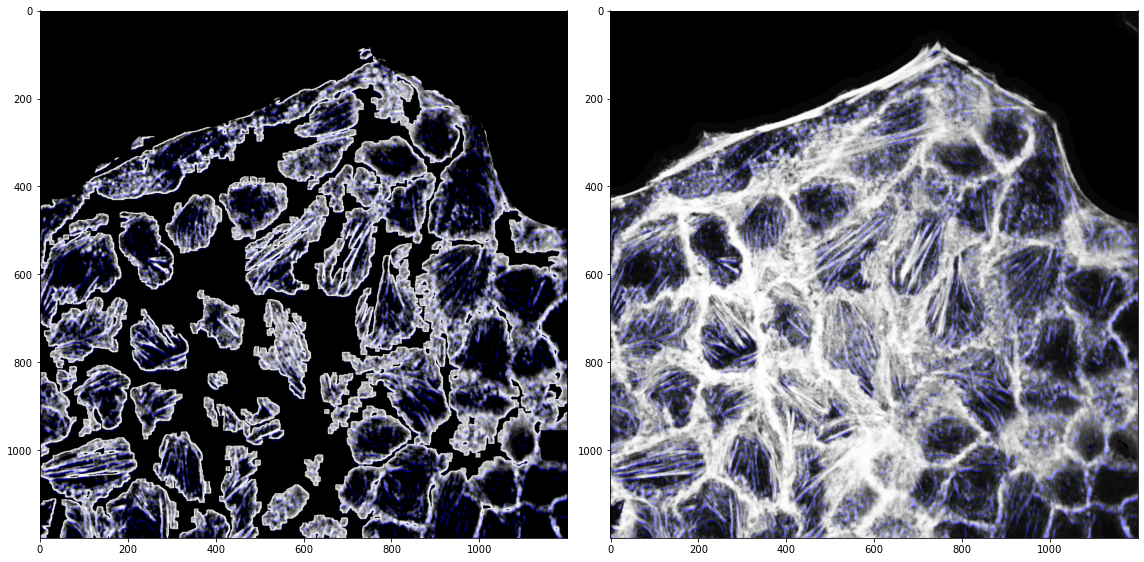

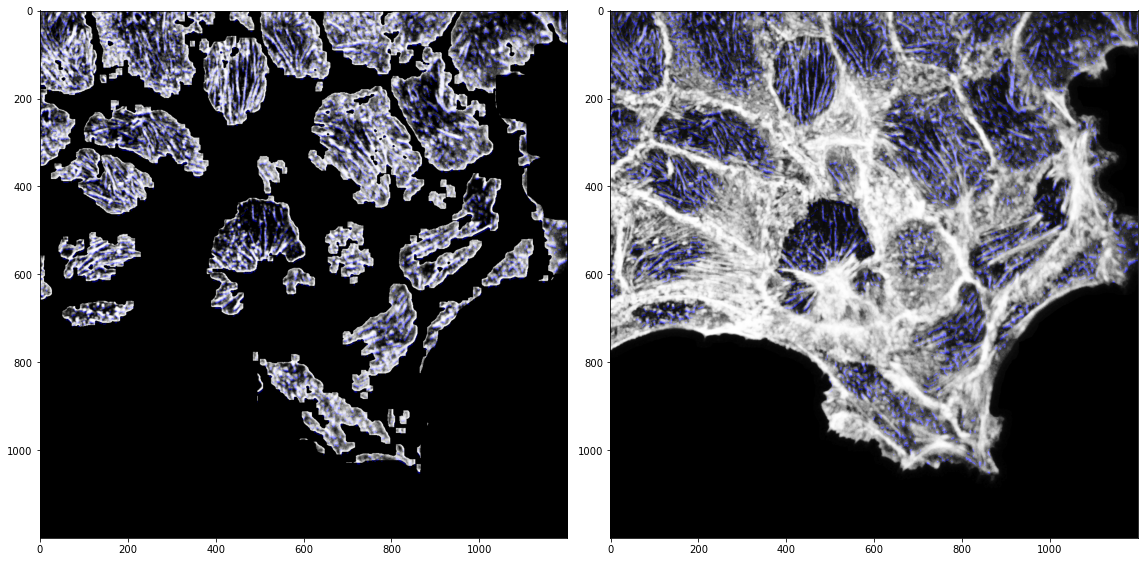

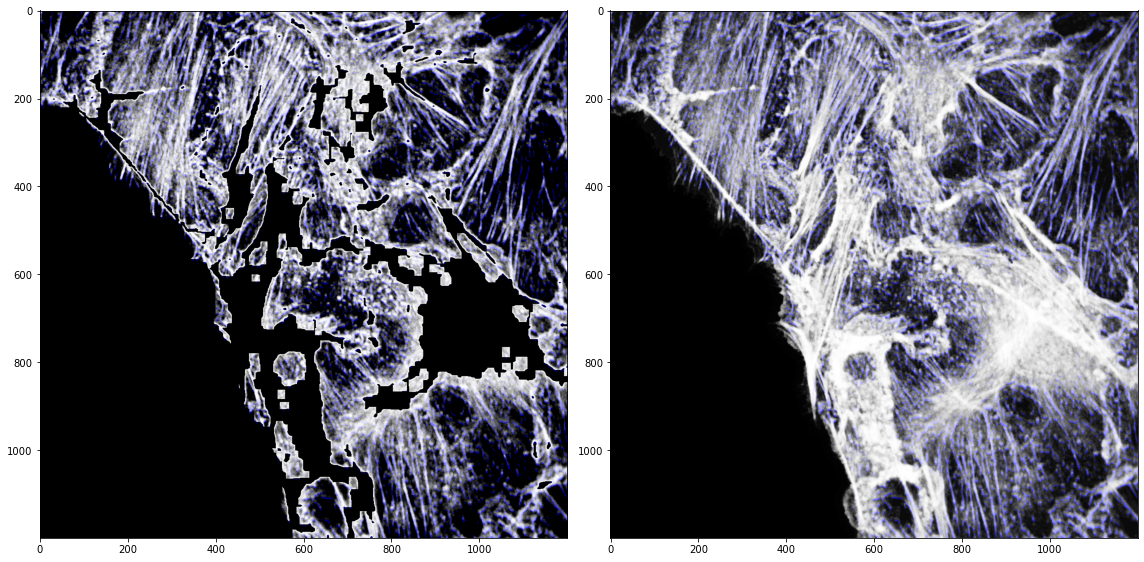

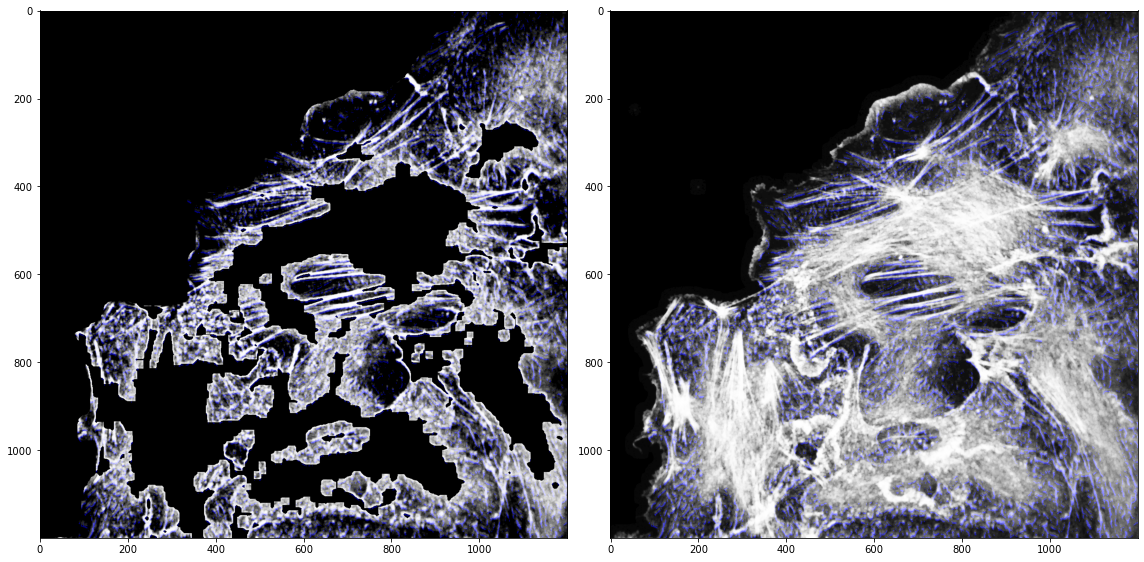

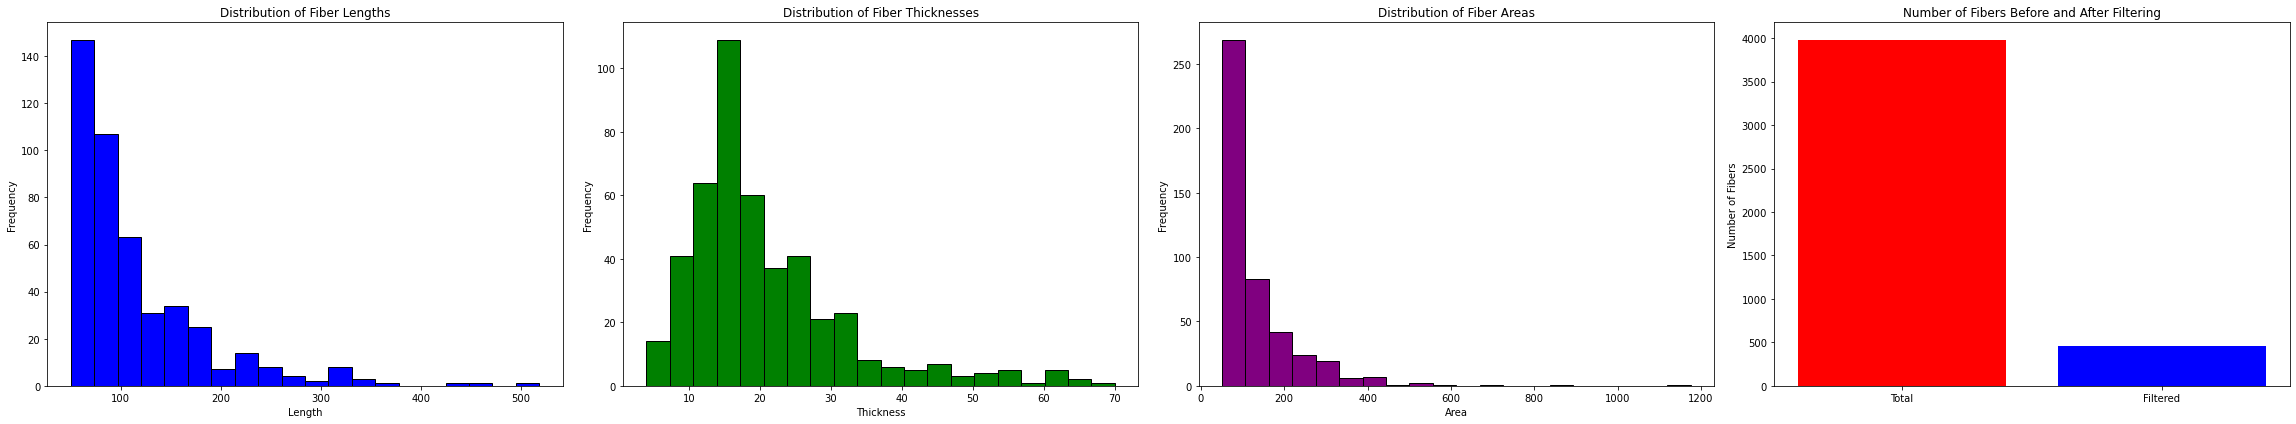

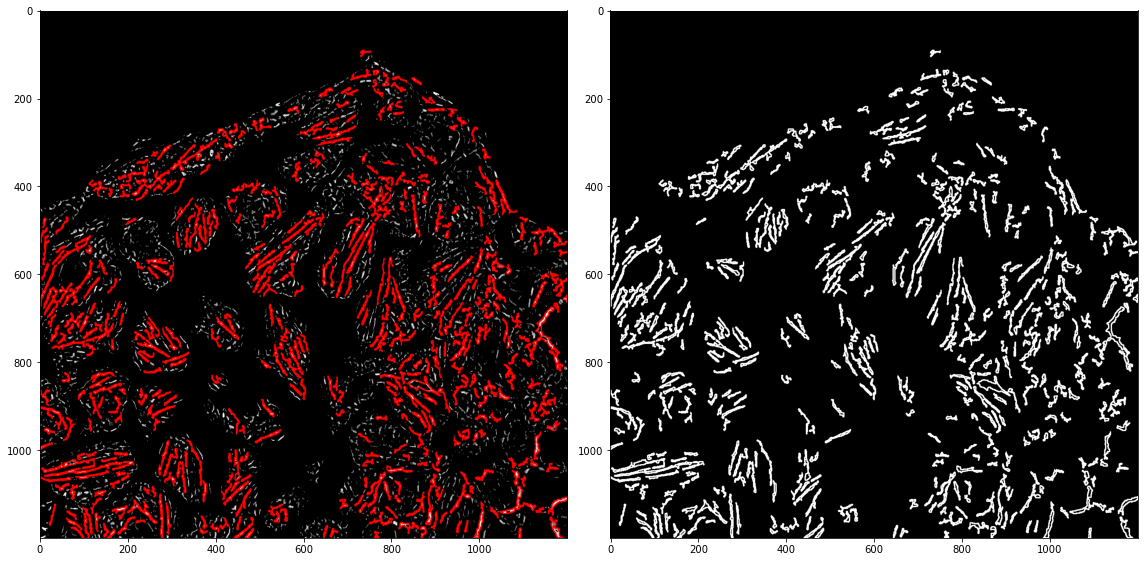

     ContourIndex      Length  Thickness   Area
0               0   60.041630         10   64.5
1               1   61.941125         19  100.0
2               2   67.112698         18   84.0
3               3   51.698484         13   56.5
4               4   52.727922          7   79.5
..            ...         ...        ...    ...
452           452   83.012193         15   77.5
453           453   98.426406         15  146.0
454           454   55.798990         12   62.0
455           455  149.396969         25  164.0
456           456   78.769552         15   68.0

[457 rows x 4 columns]


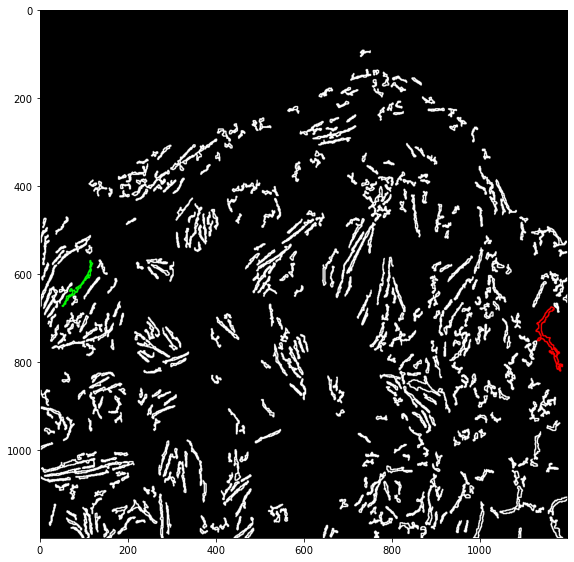

Longest Fiber Length (red): 518.2152910232544
Thickest Fiber (green): 70
Average Length of Fibers: 114.14680945586323
Average Thickness of Fibers: 20.76805251641138


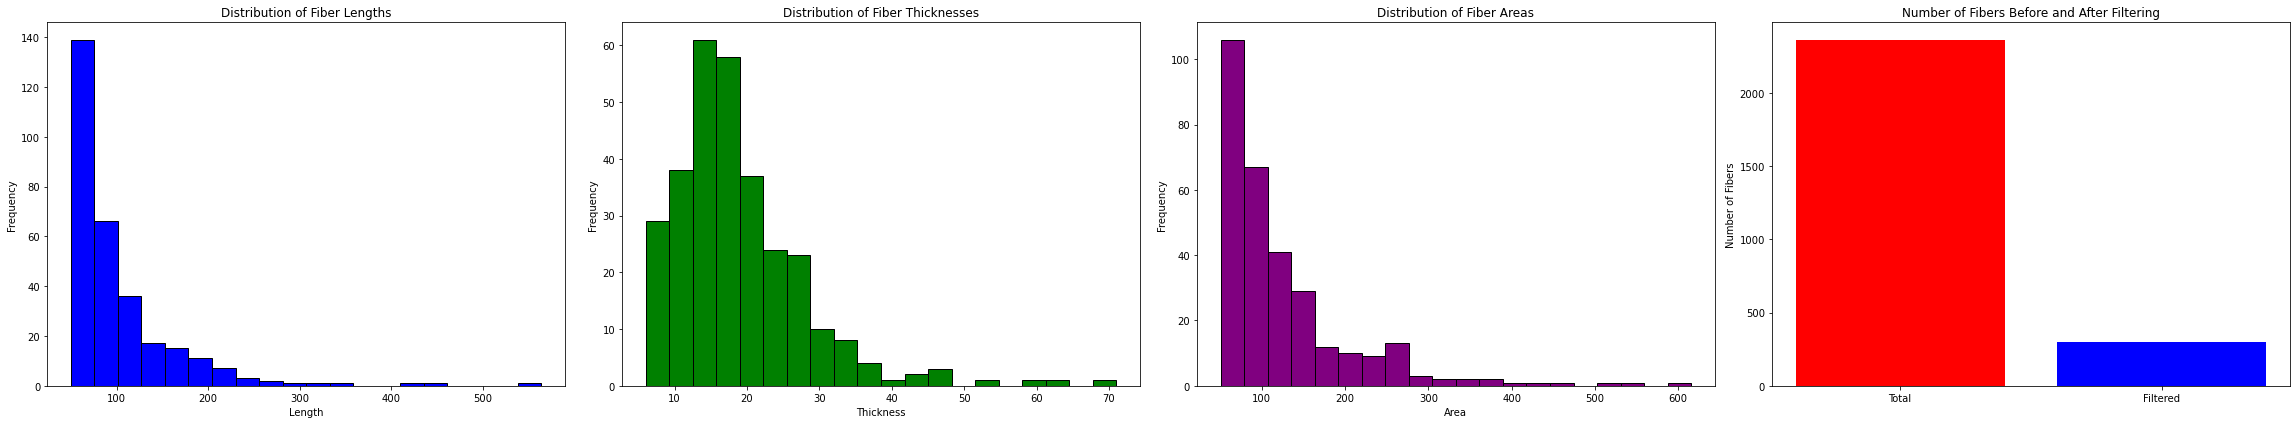

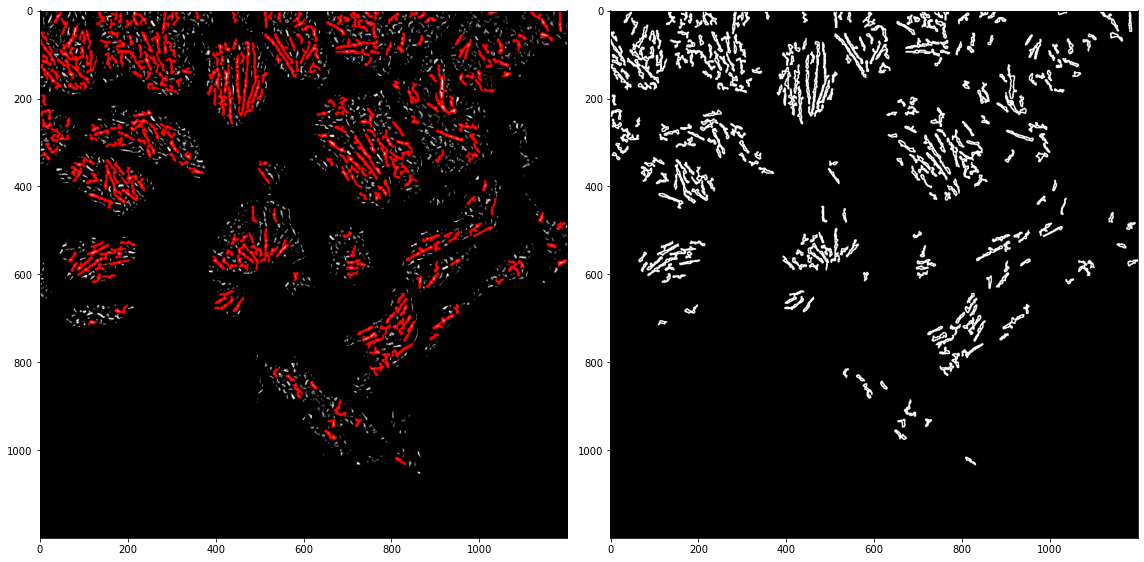

     ContourIndex      Length  Thickness   Area
0               0   66.526911         18   76.5
1               1   87.740114         22  140.0
2               2   62.970562         17  105.0
3               3   63.112698         14   74.0
4               4  146.568542         26  153.0
..            ...         ...        ...    ...
297           297  148.183766         16  185.5
298           298  193.195958         31  257.0
299           299   71.455844         14   63.0
300           300  115.254833         20  136.0
301           301   74.769552         17  106.0

[302 rows x 4 columns]


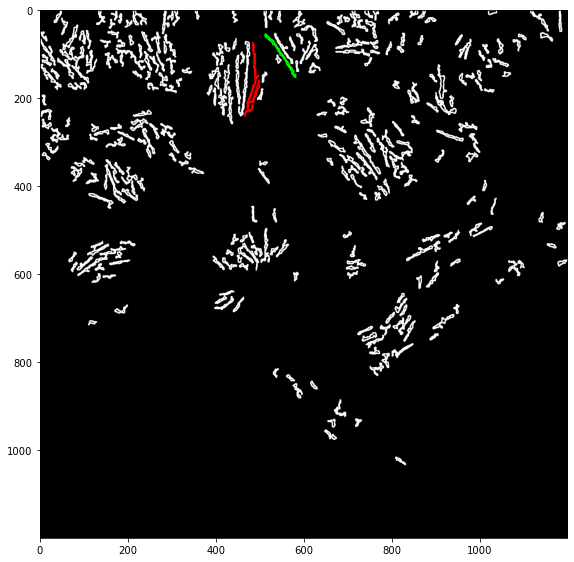

Longest Fiber Length (red): 563.8893901109695
Thickest Fiber (green): 71
Average Length of Fibers: 101.43702625873073
Average Thickness of Fibers: 18.801324503311257


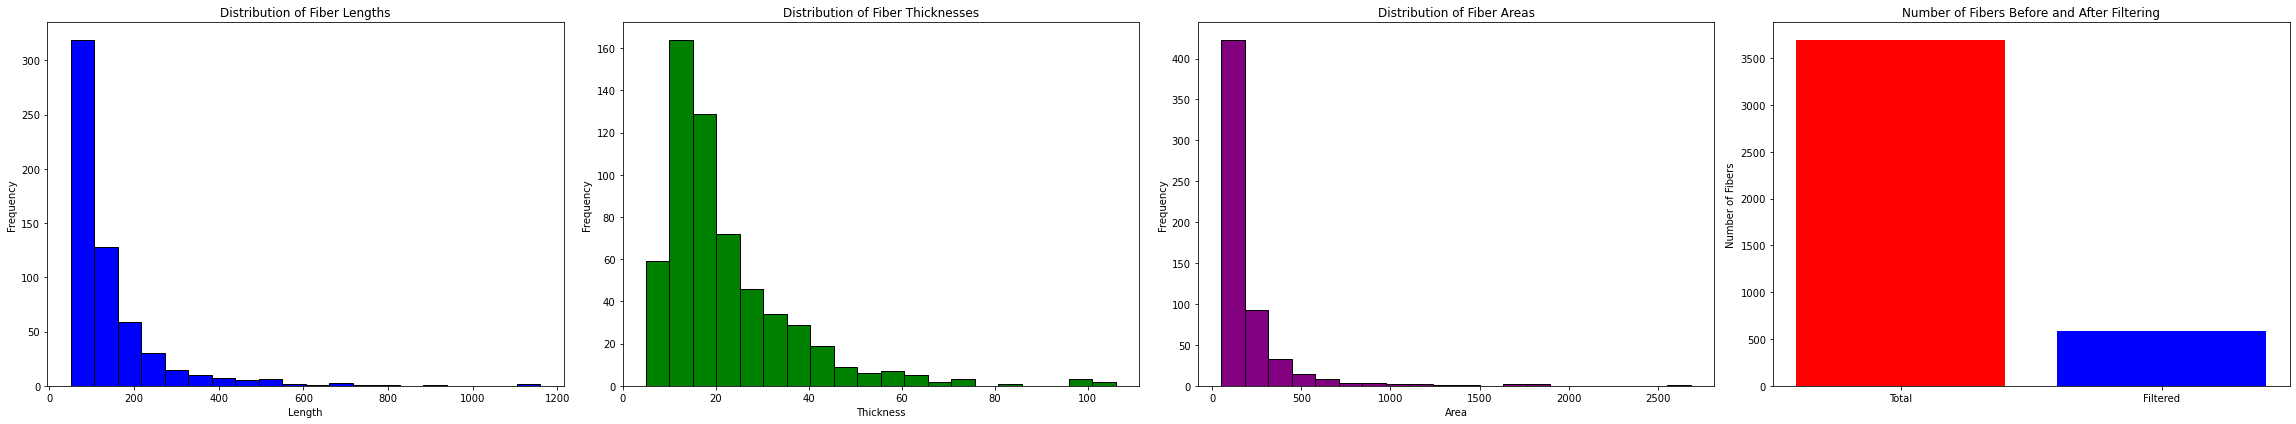

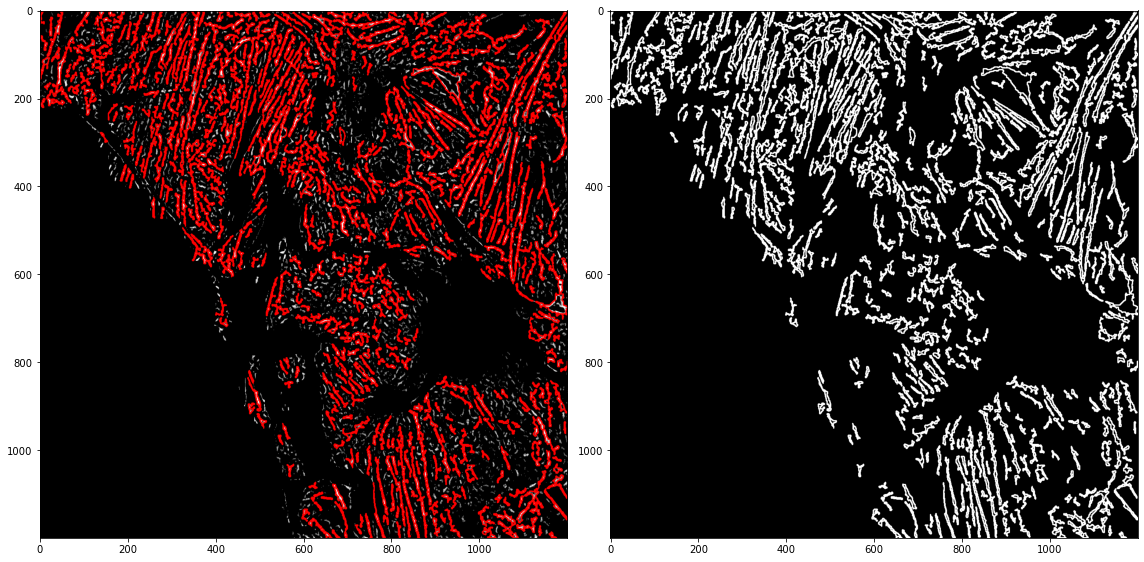

     ContourIndex      Length  Thickness   Area
0               0   57.455844         14   67.0
1               1   59.941125         18   68.0
2               2   68.284271         12   81.0
3               3  148.225396         25  235.0
4               4   54.870057          8   61.5
..            ...         ...        ...    ...
585           585   56.970562         15   83.0
586           586  123.012193         21  181.5
587           587  188.509666         35  261.0
588           588  292.894442         36  458.5
589           589   94.284271         10   63.0

[590 rows x 4 columns]


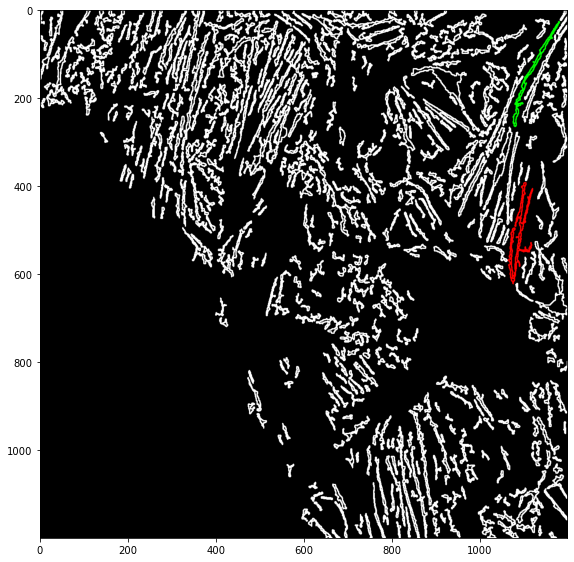

Longest Fiber Length (red): 1160.6244522333145
Thickest Fiber (green): 106
Average Length of Fibers: 141.49851440393317
Average Thickness of Fibers: 22.654237288135594


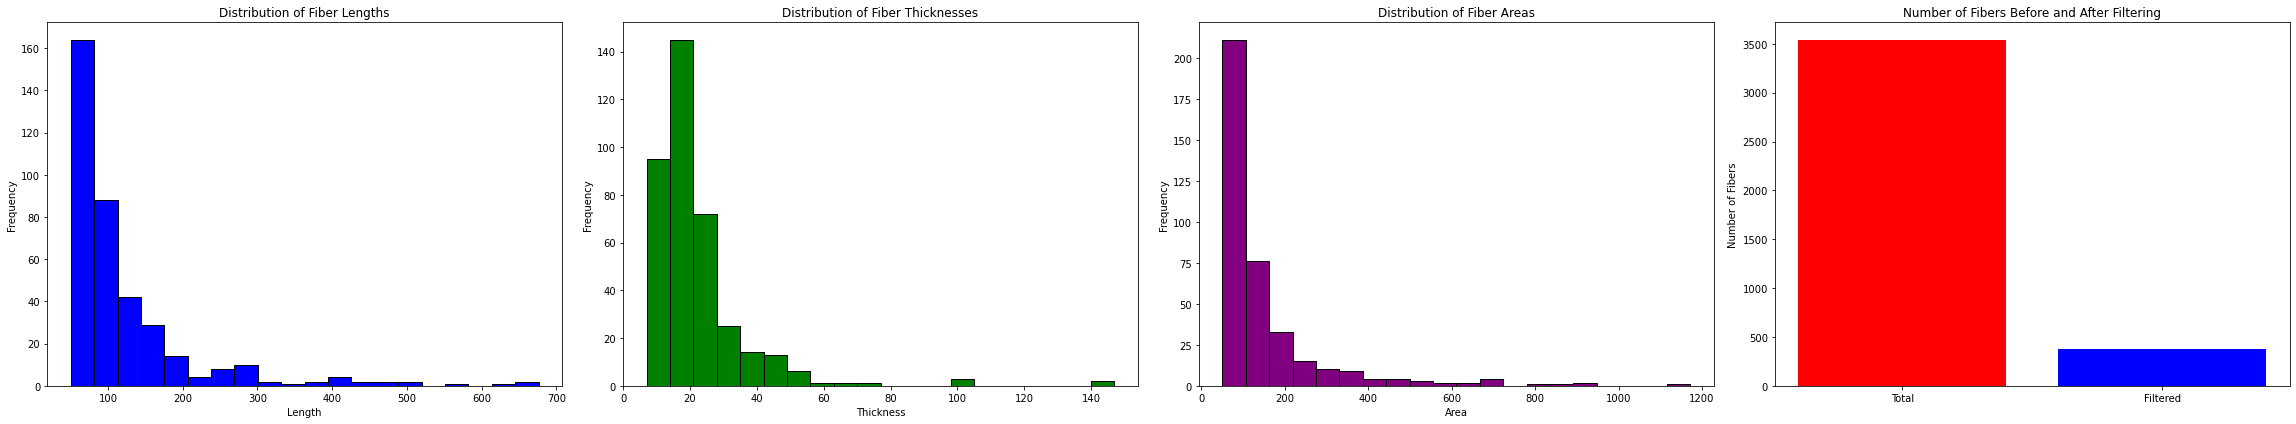

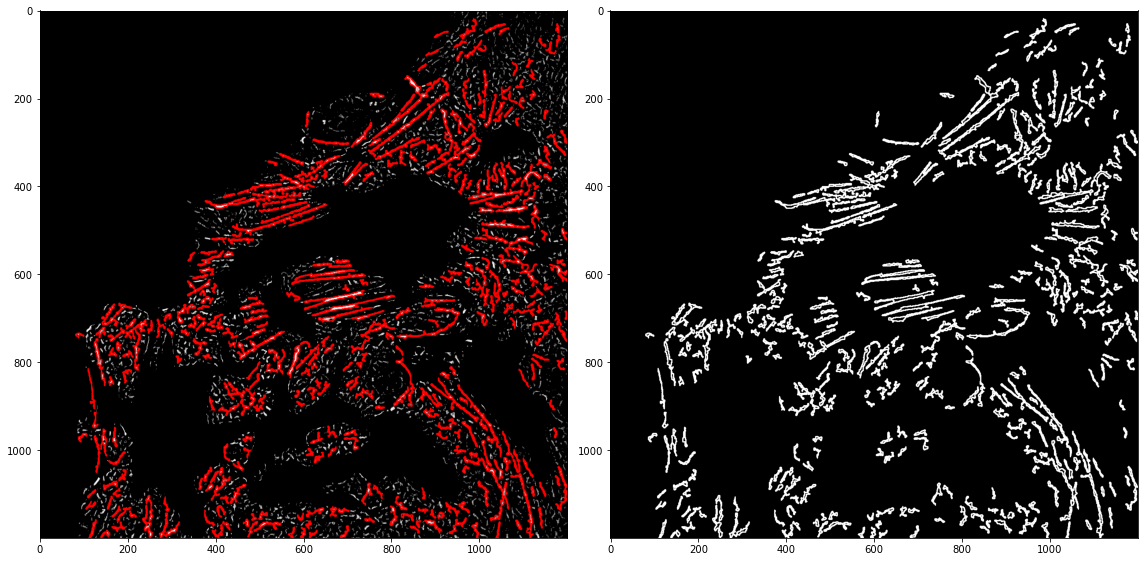

     ContourIndex      Length  Thickness   Area
0               0   69.355338         18   68.5
1               1   74.426406         18  102.0
2               2   80.183766         12   95.5
3               3   72.284271         15   82.0
4               4   62.284271         16   57.0
..            ...         ...        ...    ...
373           373   74.769552         15   62.0
374           374   64.526911         17   69.5
375           375   50.384776          8   69.5
376           376  112.083260         21  153.0
377           377  190.024385         38  214.0

[378 rows x 4 columns]


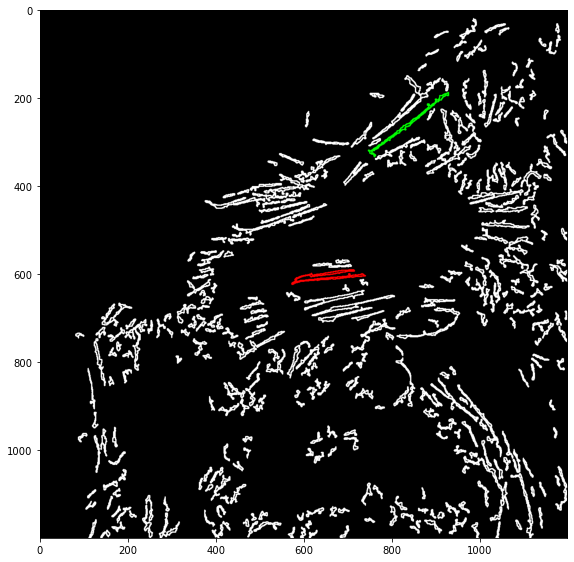

Longest Fiber Length (red): 676.1909058094025
Thickest Fiber (green): 147
Average Length of Fibers: 121.26062319928376
Average Thickness of Fibers: 21.341269841269842


In [23]:
image_files = ["pic1.tif", "pic2.tif", "pic3.tif", "pic4.tif"]
stress_fibers = find_stress_fibers(image_files)

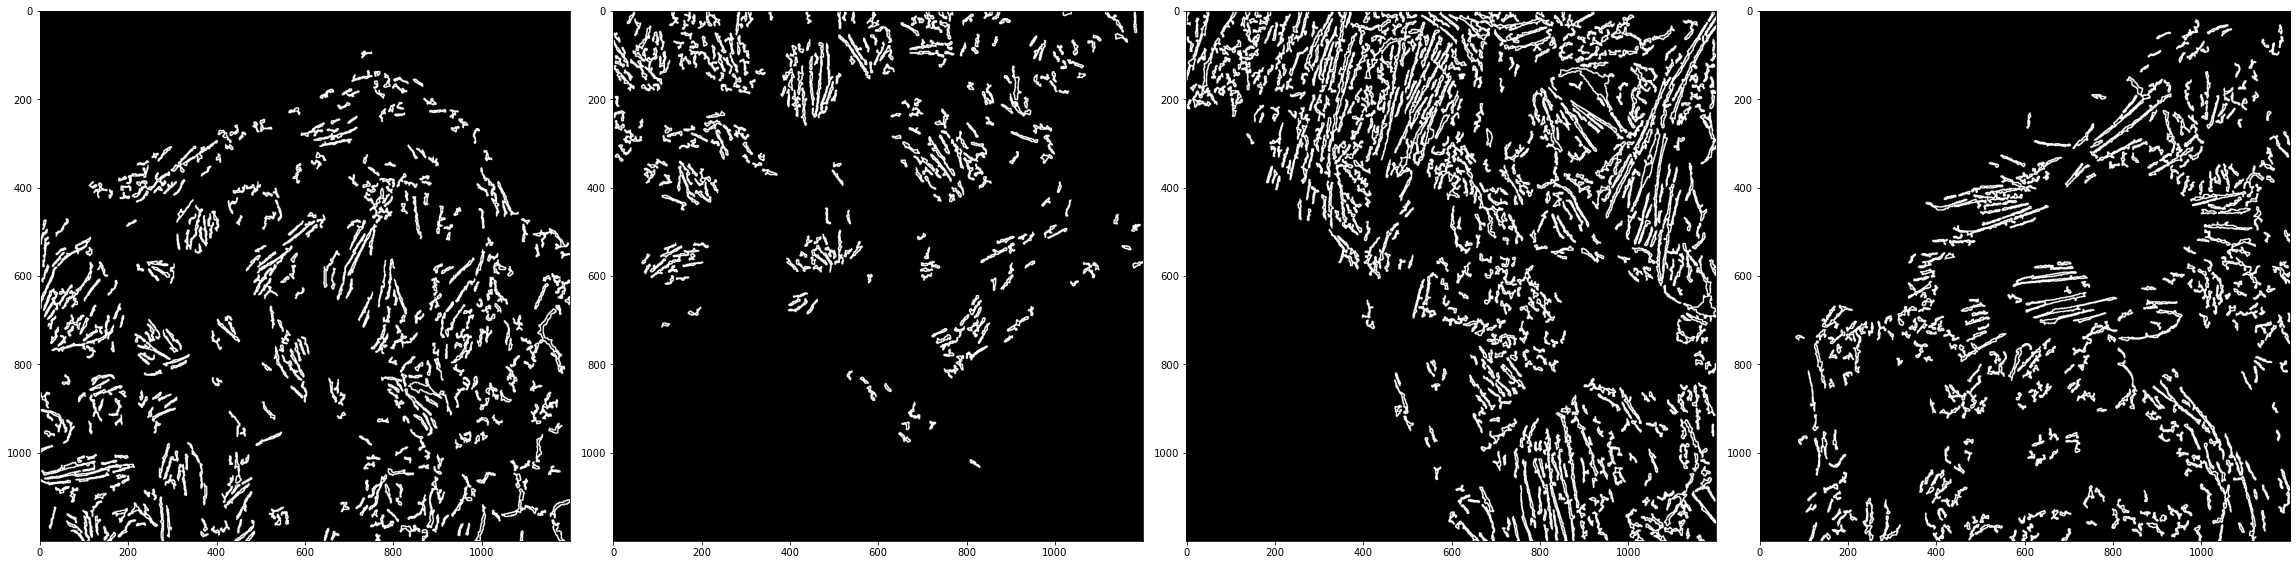

In [24]:
show(*stress_fibers)